# Some information on this notebook

Google Colab provides an efficient environment for writing codes collaboratively with your **team mates**. 

For us **teachers**, this environment makes it possible to follow your work, whether we are all face-to-face at IMT Atlantique, in hybrid mode, or totally remote. 

This notebook offers you a **skeleton** of an ILS meta-heuristics, pre-configured for the use-case on the hub location problem. 

To collaborate with your team mates on this notebook, you should : 

- First **save a copy of this file in your Google Drive**: 

  Go to **File** / **Fichier**, then click on **Save a copy in Drive** / **Sauver une copie dans Google Drive**. 

- Then, **open that copy**, and **share that copy with your team mates** (and your teacher obviously): 

  Click on the top right on **Share** / **Partager**, then in the window **Obtenir le lien**, change the sharing method **Restricted** / **Limité** to **Anyone with the link** / **Tous les utilisateurs disposant du lien**, and change **Viewer** / **Lecteur** to **Editor** / **Editeur**. Finally click on **Copy link** / **Copier le lien**, and share this link with your team mates. 

The best is probably to put that link in the header of your Mattermost team, so that your teacher and your team mates can easily find it. 

**Before starting to code**, you should execute the first cell below, which helps you to upload the data files (in Excel format) to your notebook. You can also do this by hand, by: 

- Clicking on the left on the small **folder icon**, 
- Creating a **directory** for the data files (call it data), 
- **Uploading** the two Excel files provided in the website (the small and the large problem) in that directory. 


# Upload of the data files (do only once !!)

The cell below contains some code to

- **Upload** the Excel files containing the **data** of the problems,
- **Create** a **directory** for those files (we chose to call that directory `data` for some obvious reasons),
- **Move** the data files to the `data` directory,
- **Remove** the `sample_data` directory which is created by default when a new Google Colab notebook is created.

Once executed at the beginning of your work, you can **comment this cell out** (by putting `#` in front of each line), so that it is not executed every time you execute the whole notebook ! 

In [ ]:
from google.colab import files, drive
import os
import shutil

uploaded = files.upload()
dest_path = "/content/data/"
os.makedirs(os.path.dirname(dest_path), exist_ok=True)
shutil.move("/content/InputDataHubLargeInstance.xlsx", dest_path)
shutil.move("/content/InputDataHubSmallInstance.xlsx", dest_path)
shutil.rmtree("/content/sample_data/", ignore_errors=True, onerror=None)

Saving InputDataHubLargeInstance.xlsx to InputDataHubLargeInstance.xlsx
Saving InputDataHubSmallInstance.xlsx to InputDataHubSmallInstance.xlsx


# Imports of modules

Below we import some modules necessary to make this code work properly. 

You can add other modules here which you might need for your algorithm. 

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random

# Definitions of constants

In the cell below we define some constants that we need in the meta-heuristic. 

The paths to the data files are also specified here. 

In [ ]:
# ILS parameters

ALPHA = 0.05
MAX_ITER = 150     # maximum number of iterations (Stopping criterion of ILS)
MAX_ITER_NI = 50   # number of iterations without improvement of the objective function (Stopping criterion of ILS)
MAX_ITER_LS = 100  # maximum number of iterations of the local search operator (Outer loop)
MAX_SWAPS = 1      # maximum number of swaps of the local search operator (Inner loop)
NB_SWAPS = 1       # number of swaps in the perturbation operator
NB_IMPORT = 3       # number of importing the new node

# Path to data file

#INPUT_DATA = "/content/data/InputDataHubSmallInstance.xlsx"  # Small instance
INPUT_DATA = "/content/data/InputDataHubLargeInstance.xlsx"  # Large instance

# Functions to load and prepare the data

In the cell below, you find two functions : 

- first, `read_excel_data`, which returns the values of a specific sheet in an Excel file,
- then, `create_data_model` which fills the `data` dictionary with the data from the various sheets of the Excel file, as well as some dependent data, which is calculated from the raw data.

In [ ]:
def read_excel_data(filename, sheet_name):
    data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
    values = data.values
    return values


def create_data_model():
    data = {}
    # This section contains all required data #
    node_num = read_excel_data(INPUT_DATA, "NodeNum")
    data['node_num'] = node_num[0][0]

    # Flow between Nodes Read From Excel #
    data['flow'] = read_excel_data(INPUT_DATA, "flow(wij)")

    # Cost between Nodes Read from Excel #
    data['var_cost'] = read_excel_data(INPUT_DATA, "varCost(cij)")

    # Fixed Location Cost Read from Excel #
    data['fix_cost'] = read_excel_data(INPUT_DATA, "fixCost(fk)")

    # Discount Factor Read from Excel #
    data['alpha'] = read_excel_data(INPUT_DATA, "alpha")

    # Discount Factor Read from Excel #
    data['cap'] = read_excel_data(INPUT_DATA, "Cap(ckmax)")

    # Dependent Parameters
    data['origin'] = data['flow'].sum(axis=1)
    data['destination'] = data['flow'].sum(axis=0)

    return data

# Functions to calculate the objective function from the solution representation

The cell below contains 2 functions to calculate the objective function of an individual: 
- first `prufer_to_tree` which transforms the Prüfer representation of a solution into a tree, 
- second, `compute_of` which calculates the fitness (or objective function) of an individual (or a solution).

In [ ]:
def prufer_to_tree(a):
    """Transform the Prüfer representation into a tree."""
    tree = []
    t = range(0, len(a)+2)

    # the degree of each node is how many times it appears
    # in the sequence
    deg = [1]*len(t)
    for i in a:
        deg[i] += 1

    # for each node label i in a, find the first node j with degree 1 and add
    # the edge (j, i) to the tree
    for i in a:
        for j in t:
            if deg[j] == 1:
                tree.append((i, j))
                # decrement the degrees of i and j
                deg[i] -= 1
                deg[j] -= 1
                break

    last = [x for x in t if deg[x] == 1]
    tree.append((last[0], last[1]))

    return tree


def compute_of(individual, data):
    """Calculate the objective function of the individual."""
    fitness = 100000000

    tree_edges = prufer_to_tree(individual)

    graph = nx.Graph(tree_edges)
    all_pairs_path = dict(nx.all_pairs_shortest_path(graph))

    hubs = np.unique(individual)
    fixed_cost = data['fix_cost'][hubs].sum()

    variable_cost = 0
    flow_to_hub = np.zeros(data['node_num'])
    for i in range(data['node_num']):
        for j in range(data['node_num']):
            if j > i:
                for x in range(len(all_pairs_path[i][j]) - 1):
                    route = all_pairs_path[i][j]
                    if route[x] in hubs and route[x + 1] in hubs:
                        variable_cost = variable_cost + data['alpha'] * data['var_cost'][route[x], route[x + 1]] * (data['flow'][i, j] + data['flow'][j, i])
                    else:
                        variable_cost = variable_cost + data['var_cost'][route[x], route[x + 1]] * (data['flow'][i, j] + data['flow'][j, i])

        fitness = fixed_cost + variable_cost[0]

    # Calculating the Entering flow to Each Hub #
    for i in range(len(tree_edges)):
        if tree_edges[i][0] not in hubs:
            flow_to_hub[tree_edges[i][1]] = flow_to_hub[tree_edges[i][1]] + (data['origin'][tree_edges[i][0]] + data['destination'][tree_edges[i][0]])
        elif tree_edges[i][1] not in hubs:
            flow_to_hub[tree_edges[i][0]] = flow_to_hub[tree_edges[i][0]] + (data['origin'][tree_edges[i][1]] + data['destination'][tree_edges[i][1]])
    for i in range(len(hubs)):
        flow_to_hub[hubs[i]] = flow_to_hub[hubs[i]] + (data['origin'][hubs[i]] + data['destination'][hubs[i]])

    # Feasibility Check: Capacity Constraint #
    exceed = np.subtract(data['cap'], flow_to_hub)
    exceed_cap = exceed[hubs, hubs]
    if min(exceed_cap) < 0:
        fitness = np.dot(fitness, 100000000)

    return fitness

# Functions to create solutions or individuals

The cell below contains two functions regarding individuals:

- first, `generate_individual` to create a random individual, 
- second, `initial_solution` which returns this single randomly generated individual and its fitness.

In [ ]:
def generate_individual(node_num):
    """Generate a random individual."""
    individual = np.ndarray.tolist(np.random.randint(0, high=node_num-1, size=node_num-2, dtype='int'))
    return individual


def initial_solution(data):
    """Generate a solution and calculate its objective function."""
    solution = []

    # here we are generating only one initial solution
    solution.append(generate_individual(data['node_num']))

    value_of = compute_of(solution[0], data)
   
    return solution, value_of

# Functions for the local search

In [ ]:
#This fonction is used to generate the complete two columns(hubs, spokes) corresponding to the solution
def generate_hubs_spokes(sol):
    list_hub = []
    list_spoke = []
    hubs = np.unique(sol).tolist()
    sol = list(sol)
    tree = prufer_to_tree(sol)
    for i in tree:
        elem = list(i)
        if elem[0] in hubs:
            list_hub.append(elem[0])
            list_spoke.append(elem[1])
        else:
            list_hub.append(elem[1])
            list_spoke.append(elem[0])
    return list_hub, list_spoke

In [ ]:
#This function uses the list of hubs and spokes to generate the solution(sol) that correspond to the solution after a local search
def generate_sol(list_hub, list_spoke):
    sol=[]
    #Count the depth of each node
    deg = [0]*(len(list_hub)+1)
    for i,j in zip(list_hub,list_spoke):
        deg[i] += 1
        deg[j] += 1
    #Search for the point in list of spokes with depth 1 starting from the first element and add it to sol
    for i in range(0, len(list_hub)-1):
        for j in range(0, len(list_hub)+1):
            if deg[j]==1 and j in list_spoke:
                hub_location = list_hub[list_spoke.index(j)]
                sol.append(hub_location)   
                deg[j] -= 1
                deg[hub_location] -= 1
                break
    return sol

In [ ]:
#Generate and return a generator containing combinations of numbers like(i,j) from n1 to n2
def unique_pairs(n1,n2):
    """Produce pairs of indexes in range(n1,n2)"""
    for i in range(n1,n2,1):
        for j in range(i + 1, n2, 1):
            yield i, j

In [ ]:
# The following function is a sub-function to do a single reversion move on the solution (i.e., revesing the order of elements between positions p1 and p2) 
def reverse(p1, p2, parent):
    """Reversion operator."""
    for (i,j) in unique_pairs(p1,p2):
      tmp = parent[i]
      parent[i] = parent[j]
      parent[j] = tmp
    return parent

In [ ]:
#Confirm that the solution after a series of search operations is a feasible solution
def valid(length, sol):
  #Verify that the length of the solution is equal to node_num-2
  if(len(sol) != length):
    return False
  else:
    #Confirming the structure of the tree
    label = 0 
    for i in range(0, len(sol)):
        for j in range(i, len(sol)):
            if sol[i]!= sol[j]:
              label = 1
    if label == 1:
      nb = 0
      length = int(len(sol))
      for i in range(0, len(sol)//2):
        if(sol[i]==sol[length-i-2]):
          nb = nb+1
      if(nb != len(sol)//2):
        return True
    return False

In [ ]:
#The first method of local search----swap on the spokes

def reverse_neighborhood(sol, best_of, data):
    
    """Neighborhood generation with a reversion operator."""
    #generate the complete list of spokes and the list of hubs that describe the relation between the hubs and spokes with length of node_num-1 
    list_hub, list_spoke = generate_hubs_spokes(sol)
    parents = []
    #generate the list of nodes which are the hubs 
    hubs = np.unique(sol).tolist()
    #generate the list of nodes which are the spokes
    for i in list_spoke:
        if i not in hubs:
            parents.append(i)

    #reverse parent in MAX_SWAPS times
    nb_swaps = 0
    #The variable used to record whether optimization is generated
    label = 0
    solutions = []
    while nb_swaps <= MAX_SWAPS :
        nb_swaps += 1
        size = len(parents)
        #Generate two random numbers between 0 and size to provide the starting and ending positions of the reversed elements
        p1 = np.ndarray.tolist(np.random.randint(0, high=size/2, size=1, dtype='int'))[0]
        p2 = np.ndarray.tolist(np.random.randint(size/2, high=size, size=1, dtype='int'))[0]
        #result is the list of spokes that has been reversed 
        result = reverse(p1, p2, parents)*1
        for i in range(0,len(list_spoke)):
            if list_spoke[i] not in hubs:
              list_spoke[i] = result[0]
              result.pop(0)
        new_sol = generate_sol(list_hub, list_spoke)
        if valid(len(list_hub)-1, new_sol):
          new_of = compute_of(new_sol,data)[0]
          if(new_of < best_of):
            parents = reverse(p1, p2, parents)
            best_of = new_of
            sol = new_sol
            label = 1
    return [sol,best_of],label

In [ ]:
#The second method of local search-----Re-allocation of single spokes to the existing Hubs
def re_allocation(sol, best_of, data):
    #generate the complete list of spokes and the list of hubs that describe the relation between the hubs and spokes with length of node_num-1 
    list_hub, list_spoke = generate_hubs_spokes(sol)
    parents = []
    #generate the list of nodes which are the hubs 
    hubs = np.unique(sol).tolist()
    #generate the list of nodes which are the spokes
    for i in list_spoke:
        if i not in hubs:
            parents.append(i)
    #generate the location to re-allocation of single spokes to the existing Hubs
    index = np.ndarray.tolist(np.random.randint(0, high=len(list_hub), size=1, dtype='int'))[0]
    solution = [sol]
    values = [best_of]
    hubs.remove(list_hub[index])
    for i in hubs:
        list_hub[index] = i
        new_sol = generate_sol(list_hub, list_spoke)
        if valid(len(list_hub)-1, new_sol):
            solution.append(new_sol)
            values.append(compute_of(new_sol,data)[0])
    best_value = min(values)
    sol1 = solution[values.index(best_value)]
    if(best_of > best_value):
        return [sol1, best_value],1
    else:
        return [sol, best_of],0

In [ ]:
#The third method of local search-----Adding new node to the solution
def import_new_hub(sol, best_of, data):
    list1 = list(range(0, data['node_num']))
    parent = []
    hubs = np.unique(sol).tolist()
    for i in list1:
      if i not in hubs:
        parent.append(i)
    nb_import = 0
    solution = [sol]
    values = [best_of]
    while nb_import < NB_IMPORT: 
      nb_import = nb_import+1
      new_sol = sol*1
      i = np.ndarray.tolist(np.random.randint(0, high=len(parent), size=1, dtype='int'))[0]
      j = np.ndarray.tolist(np.random.randint(0, high=len(sol), size=1, dtype='int'))[0]
      new_sol[j] = parent[i]
      solution.append(new_sol)
      values.append(compute_of(new_sol,data)[0])
    best_value = min(values)
    sol1 = solution[values.index(best_value)]
    if(best_of > best_value):
      return [sol1, best_value],1
    else:
      return [sol, best_of],0

In [ ]:
## This function is for the local search operator

def local_search(of, sol, data):
    """Perform a local search."""
    # number of iterations local search
    nb_iterations = 0
    best_of = of
    solutions = []
    best = []
    solutions.append(sol)
    best.append(of)
    # Main loop local search
    # Local search operators is repeated MAX_ITER_LS times
    while nb_iterations <= MAX_ITER_LS:
        nb_iterations += 1
        # use an operator to perform local search
        # The first methode to implement local research
        of ,n= reverse_neighborhood(sol, best_of, data)
        # if n==1, it shows that we have the better solution to replace the solution now
        if(n==1):
          solutions.append(of[0])
          best.append(of[1])
          sol = of[0]
          best_of = of[1]
        # The second methode to implement local research
        of, n= re_allocation(sol, best_of, data)
        if(n==1):
          solutions.append(of[0])
          best.append(of[1])
          sol = of[0]
          best_of = of[1]
        # The third methode to implement local research
        of, n= import_new_hub(sol, best_of, data)
        if(n==1):
          solutions.append(of[0])
          best.append(of[1])
          sol = of[0]
          best_of = of[1]
    best_of = min(best)
    best_sol = solutions[best.index(best_of)]
    return best_of, best_sol

# Functions for the perturbation of solutions

In [ ]:
# The following function is a sub-function to do a single swap move on the solution (i.e., changing the elements at positions p1 and p2)
def swap(i, j, sol):
    """Swap operator."""
    tmp = sol[i]
    sol[i] = sol[j]
    sol[j] = tmp

In [ ]:
def random_swap(sol,data):
  for k in range(NB_SWAPS):
    i,j=random.sample(range(0,len(sol)),2)
    swap(i,j,sol)
  return sol

In [ ]:
def perturb(sol, data):
  pert_sol = random_swap(sol,data)
  pert_of = compute_of(pert_sol, data)
  return pert_of[0], pert_sol

# Main


Random solution
Initial objective function value: [3.34397708e+16]
Solution: [[28, 25, 23, 28, 19, 20, 22, 6, 20, 27, 28, 0, 0, 20, 13, 23, 0, 20, 3, 13, 13, 26, 19, 21, 21, 28, 27, 4]]
tree: [(28, 1), (25, 2), (23, 5), (28, 7), (19, 8), (20, 9), (22, 10), (6, 11), (20, 6), (27, 12), (28, 14), (0, 15), (0, 16), (20, 17), (13, 18), (23, 22), (0, 23), (20, 0), (3, 20), (13, 3), (13, 24), (26, 13), (19, 25), (21, 19), (21, 26), (28, 21), (27, 28), (4, 27), (4, 29)]

Local Search
Objective function value: [3.34397708e+16]
Tour: [28, 25, 23, 28, 19, 20, 22, 6, 20, 27, 28, 0, 0, 20, 13, 23, 0, 20, 3, 13, 13, 26, 19, 21, 21, 28, 27, 4]
[(28, 1), (25, 2), (23, 5), (28, 7), (19, 8), (20, 9), (22, 10), (6, 11), (20, 6), (27, 12), (28, 14), (0, 15), (0, 16), (20, 17), (13, 18), (23, 22), (0, 23), (20, 0), (3, 20), (13, 3), (13, 24), (26, 13), (19, 25), (21, 19), (21, 26), (28, 21), (27, 28), (4, 27), (4, 29)]


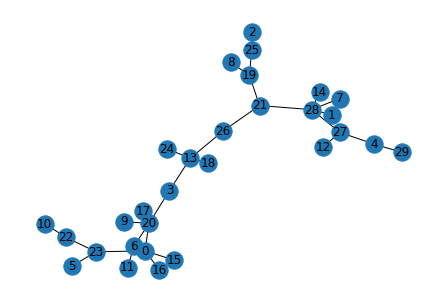

best_of_pert:  1 1.614256496e+16
best_of_pert:  2 1.5097477950000006e+16
best_of_pert:  3 1.4986319630000002e+16
best_of_pert:  4 1.4575978110000006e+16
best_of_pert:  5 1.4177420489999994e+16
best_of_pert:  6 1.4046022079999998e+16
best_of_pert:  7 1.4046022079999998e+16
best_of_pert:  8 1.4046022079999998e+16
best_of_pert:  9 1.4573684199999998e+16
best_of_pert:  10 1.4122273359999994e+16
best_of_pert:  11 1.4289450899999992e+16
best_of_pert:  12 1.3810358569999992e+16
best_of_pert:  13 1.365744797999999e+16
best_of_pert:  14 1.3889126179999986e+16
best_of_pert:  15 1.3599962959999984e+16
best_of_pert:  16 1.3623577549999988e+16
best_of_pert:  17 1.357056595999999e+16
best_of_pert:  18 1.357056595999999e+16
best_of_pert:  19 1.361230252999999e+16
best_of_pert:  20 1.361230252999999e+16
best_of_pert:  21 1.3793327099999994e+16
best_of_pert:  22 1.3789752059999994e+16
best_of_pert:  23 1.376433011999999e+16
best_of_pert:  24 1.3825510129999998e+16
best_of_pert:  25 1.3625605989999992e+

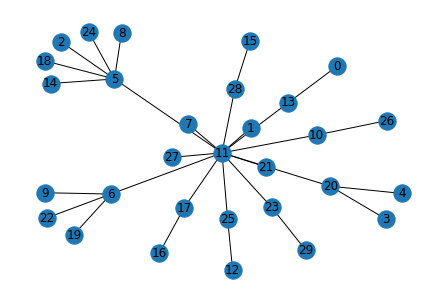

In [ ]:
if __name__ == "__main__":
    # *************************Initialisation***************************
    # initialise the data
    data = create_data_model()

    # init number of iterations
    nb_iterations = 0

    # find initial solution (just one) with a constructive heuristic
    best_sol, best_of = initial_solution(data)

    # ********************************************************************

    print("Random solution")
    print("Initial objective function value:", best_of)
    print("Solution:", best_sol)
    print("tree:", prufer_to_tree(best_sol[0]))
    # **************************Local Search******************************

    best_of, best_sol = (best_of, best_sol[0])
    best_known = best_sol
    best_of_known = best_of

    print("\nLocal Search")
    print("Objective function value:", best_of)
    print("Tour:", best_sol)

    best_solution = prufer_to_tree(best_sol)

    print(best_solution)

    graph = nx.Graph(best_solution)
    plt.figure(2)
    nx.draw(graph, with_labels=True)
    plt.show()

    # ********************************************************************

    # ******************************ILS***********************************
    flag_continue = True
    improve = 0

    while flag_continue and nb_iterations <= MAX_ITER and improve <= MAX_ITER_NI:

        nb_iterations += 1
        # ******************Perturbation**********************************
        pert_of, pert_sol = perturb(best_sol, data)
        # print(pert_of)

        # ******************Local Search***********************************
        best_of_pert, best_sol_pert = local_search(pert_of, pert_sol, data)
        print("best_of_pert: " ,nb_iterations, best_of_pert)

        # ******************Aceptance criterion***************************
        if best_of_pert < best_of_known:
            best_known = best_sol_pert
            best_of_known = best_of_pert
            improve = 0
        else:
            improve += 1

        if best_of_pert < best_of * (1 + ALPHA):
            best_of = best_of_pert
            best_sol = best_sol_pert
        else:
            flag_continue = False

    print("\n")
    print("After", nb_iterations, " ILS iterations, the best solution is:")
    print(best_known)
    print("with total cost:", best_of_known)

    print("improve:", improve, MAX_ITER_NI)
    print("flag_continue:", flag_continue)

    best_solution = prufer_to_tree(best_known)

    graph = nx.Graph(best_solution)
    plt.figure(2)
    nx.draw(graph, with_labels=True)
    plt.show()